In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
from enum import Enum
from typing import Tuple, Optional, Literal
from abc import ABC, abstractmethod
from dataclasses import dataclass

import pandas as pd
import numpy as np
import numba as nb
import torch
from torch.nn import Linear, ReLU
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm

from pyquant.heston_sim import *
from pyquant.heston import *
from pyquant.common import *
from pyquant.barrier import barrier_option_payoff, price_barrier_option
from pyquant.lsm import price_american_put_lsm

In [2]:
RANDOM_SEED = 90909090
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

CALIBR_DATA_DIR = 'calibration_data'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

In [3]:
class InstrumentType(Enum):
    FUTURE = 1
    OPTION = 2
    FUTURE_COMBO = 3
    OPTION_COMBO = 4
    CALL_OPTION = 5
    PUT_OPTION = 6
    ASSET = 7


class OptType(Enum):
    PUT = False
    CALL = True

    def to_instr_type(self) -> InstrumentType:
        if self.name == 'PUT':
            return InstrumentType.PUT_OPTION
        else:
            return InstrumentType.CALL_OPTION


class BaseOption(ABC):
    def __init__(self, strike: float, expiry_ts: int, opt_type: OptType):
        """
        Args:
            strike: Strike price of the option.
            expiry_ts: Expiration timestamp in nanoseconds.
        """
        self._strike: float = strike
        self._expiry_ts: int = expiry_ts
        self._type = opt_type
        self._ts: Optional[int] = None
        self._rate: Optional[float] = None
        self._time_to_expiry: Optional[float] = None
        self._are_params_set = False

    @property
    def get_type(self) -> OptType:
        return self._type

    @property
    def strike(self):
        return self._strike

    @property
    def expiry_ts(self):
        return self._expiry_ts

    @property
    def time_to_expiry(self):
        return self._time_to_expiry

    def set_params(self, ts: int, rate: float):
        """Sets current market parameters and Heston model parameters.

        Args:
            ts: Timestamp in nanoseconds
            rate: Forward yield.
        """
        self._ts = ts
        self._rate = rate
        self._time_to_expiry = (self._expiry_ts - self._ts) / YEAR_NANOS
        self._are_params_set = True

    def find_expiry_idx(self, paths: torch.Tensor, dt: float):
        time = np.zeros(paths.shape[1])
        time[1] = dt
        time = torch.cumsum(time)
        expiry_idx = torch.argmin(torch.abs(time - self.time_to_expiry))
        return expiry_idx

    @abstractmethod
    def get_payoff(self, paths: torch.Tensor, dt: float) -> torch.Tensor:
        if not self._are_params_set:
            raise ValueError('Cannot calculate payoff because `self.set_params()` was never called')

    @abstractmethod
    def get_premium(self, paths: torch.Tensor, dt: float) -> torch.Tensor:
        if not self._are_params_set:
            raise ValueError('Cannot calculate premium because `self.set_params()` was never called')


class VanillaOption(BaseOption):
    def __init__(self, strike: float, expiry_ts: int, opt_type: OptType):
        super().__init__(strike, expiry_ts, opt_type)

    def get_payoff(self, paths, dt) -> torch.Tensor:
        super.get_payoff(paths, dt)
        expiry_idx = self.find_expiry_idx(paths, dt)
        sign = -1 if self._type == OptType.PUT else 1
        payoffs = torch.maximum(sign * (paths[:, expiry_idx] - self._strike),
                               torch.zeros_like(paths[:, expiry_idx]))
        return payoffs

    def get_premium(self, paths, dt) -> torch.Tensor:
        super().get_premium(paths, dt)
        sign = -1 if self._type == OptType.PUT else 1
        payoffs = torch.maximum(sign * (paths[:, -1] - self._strike), torch.zeros_like(paths[:, -1]))
        n_steps = paths.shape[1] - 1
        T = dt * n_steps
        premium = torch.exp(torch.tensor(-self._rate * T)) * torch.mean(payoffs)
        return premium


class BarrierOption(BaseOption):
    def __init__(
        self,
        strike: float,
        expiry_ts: int,
        opt_type: OptType,
        barrier_price: float,
        barrier_type: Literal['up-in', 'up-out', 'down-in', 'down-out']
    ):
        super().__init__(strike, expiry_ts, opt_type)
        self._barrier_price = barrier_price
        self._barrier_type = barrier_type

    def get_payoff(self, paths, dt) -> torch.Tensor:
        super.get_payoff(paths, dt)
        expiry_idx = self.find_expiry_idx(paths, dt)
        return barrier_option_payoff(
            paths[:, expiry_idx], self._strike, self._barrier_price,
            self._barrier_type, self.opt_type.value
        )

    def get_premium(self, paths, dt):
        super().get_premium(paths, dt)
        n_steps = paths.shape[1] - 1
        T = dt * n_steps
        premium = price_barrier_option(
            paths, self._strike, T, self._rate, self._barrier_price,
            self._barrier_type, self.get_type.value
        )
        return premium


class AmericanOption(BaseOption):
    # TODO: implement
    
    def __init__(self, strike: float, expiry_ts: int, opt_type: OptType):
        super().__init__(strike, expiry_ts, opt_type)

    def get_payoff(self, paths, dt) -> torch.Tensor:
        super.get_payoff(paths, dt)

    def get_premium(self, paths, dt):
        super().get_premium(paths, dt)


class HestonPortfolio:
    def __init__(
        self,
        options: Tuple[BaseOption],
        n_paths: int,
        max_dt: float,
        min_steps: int,
        minimum_var: float = 0.005
    ):
        self._options: Tuple[BaseOption] = options
        self.n_paths: int = n_paths
        self.max_dt: float = max_dt
        self.min_steps: int = min_steps
        self.minimum_var: float = minimum_var

        self.ts: Optional[int] = None
        self.spot: Optional[float] = None
        self.heston_params: HestonParams = None

        self.times_to_expiry: Optional[list[float]] = None
        self.unique_tte: Optional[np.ndarray[float]] = None
        self.unique_tte_idxs: Optional[np.ndarray[int]] = None
        self.tte_idxs_inverse: Optional[np.ndarray[int]] = None
        self.dt: Optional[list[float]] = None
        self.n_steps: Optional[list[int]] = None

        self._premiums: Optional[list[float]] = None
        self._deltas: Optional[list[float]] = None
        self._vegas: Optional[list[float]] = None

    def set_params(
        self,
        ts: int,
        spot: float,
        heston_params: HestonParams,
    ):
        """Sets current market parameters and Heston model parameters.

        Args:
            ts: Timestamp in nanoseconds.
            spot: Spot price.
            heston_params: Heston parameters.
        """
        self.ts = ts
        self.spot = spot
        self.heston_params = heston_params

        for option in self._options:
            option.set_params(self.ts, self.heston_params.r)
        
        self.times_to_expiry = [opt.time_to_expiry for opt in self._options]
        self.unique_tte, self.unique_tte_idxs, self.tte_idxs_inverse = \
            np.unique(self.times_to_expiry, return_index=True, return_inverse=True)
        
        self.dt = []
        self.n_steps = []
        
        for tte in self.unique_tte:
            if tte <= 0:
                self.dt.append(None)
                self.n_steps.append(None)
                continue
            
            dt = tte / self.min_steps
            if dt > self.max_dt:
                self.dt.append(self.max_dt)
                self.n_steps.append(round(tte / self.dt[-1]))
            else:
                self.dt.append(dt)
                self.n_steps.append(self.min_steps)

    def calculate_greeks(self):
        self._premiums = [0 for _ in range(len(self._options))]
        self._deltas = [0 for _ in range(len(self._options))]
        self._vegas = [0 for _ in range(len(self._options))]
        
        for tte_idx in range(len(self.unique_tte)):
            if self.unique_tte[tte_idx] <= 0:
                continue
            
            S0 = torch.tensor(self.spot, requires_grad=True)
            V0 = torch.tensor(self.heston_params.v0, requires_grad=True)
            init_price = S0 * torch.ones(self.n_paths)
            init_var = V0 * torch.ones(self.n_paths)
            paths, _ = generate_heston(
                self.n_paths,
                self.n_steps[tte_idx],
                self.dt[tte_idx],
                init_price,
                init_var,
                torch.tensor([self.heston_params.kappa]),
                torch.tensor([self.heston_params.theta]),
                torch.tensor([self.heston_params.eps]),
                torch.tensor([self.heston_params.rho]),
                torch.tensor([self.heston_params.r]),
                self.minimum_var
            )

            opt_idxs = np.where(self.tte_idxs_inverse == tte_idx)[0]
            for opt_idx in opt_idxs:
                premium = self._options[opt_idx].get_premium(paths, self.dt[opt_idx])
                delta, vega = torch.autograd.grad(premium, [S0, V0], retain_graph=True)
                self._premiums[opt_idx] = premium.item()
                self._deltas[opt_idx] = delta.item()
                self._vegas[opt_idx] = vega.item()

    @property
    def options(self):
        return self._options

    @property
    def premiums(self):
        return self._premiums

    @property
    def deltas(self):
        return self._deltas

    @property
    def vegas(self):
        return self._vegas


@dataclass
class OptionConfig:
    strike: float
    expiry_ts: int
    opt_type: OptType


class Backtester:
    def __init__(
        self,
        market_data: pd.DataFrame,
        calibr_data: pd.DataFrame,
        start_date: Optional[str],
        end_date: Optional[str],
        portfolio: HestonPortfolio,
        vega_option_cfg: OptionConfig,
        fee_option: float,
        fee_option_max_from_price: float,
        strat_cfg: dict
    ):
        self.portfolio = portfolio
        self.vega_option_cfg = vega_option_cfg
        self.strat_cfg = strat_cfg
        self.fee_option = fee_option
        self.fee_option_max_from_price = fee_option_max_from_price

        vega_option = VanillaOption(
            self.vega_option_cfg.strike,
            self.vega_option_cfg.expiry_ts,
            self.vega_option_cfg.opt_type
        )
        self.vhedge_portf = HestonPortfolio(
            [vega_option], self.portfolio.n_paths, self.portfolio.max_dt,
            self.portfolio.min_steps, self.portfolio.minimum_var
        )

        if start_date is not None:
            ts_mask1 = calibr_data['timestamp'] >= pd.to_datetime(start_date)
        else:
            ts_mask1 = np.full(len(calibr_data), True)
        if end_date is not None:
            ts_mask2 = calibr_data['timestamp'] <= (pd.to_datetime(end_date) + pd.to_timedelta('1 day'))
        else:
            ts_mask2 = np.full(len(calibr_data), True)

        self.calibr_data = calibr_data[ts_mask1 & ts_mask2]
        self.market_data = market_data[market_data['sample_idx'].isin(self.calibr_data['sample_idx'])]

        self._results = None
        self._curr_md = None
        self._curr_cal = None
        self._curr_md_spot = None
        self._curr_md_vega = None

        self.net_worth_history = []
        self.pos_base_history = {'spot': [], 'vega_opt': []}
        self.pos_quote_history = []
        self.fee_history = []

        self.portf_init_premium = None
        self.pos_base = {'spot': 0, 'vega_opt': 0}
        self.pos_quote = 0
        self.fee_paid = 0
        self.net_worth = 0

        self.portf_prev_delta = 0.0
        self.portf_prev_vega = 0.0
        self.vhedge_portf_prev_delta = 0.0
        self.vhedge_portf_prev_vega = 0.0
        
        self.delta = 0
        self.vega = 0

    def _set_current_md(self, idx):
        self._curr_cal = self.calibr_data.iloc[idx]
        self._curr_md = self.market_data[self.market_data['sample_idx'] == self._curr_cal['sample_idx']]

        curr_md_spot = self._curr_md[self._curr_md['instrument_type'] == InstrumentType.ASSET.value]
        assert len(curr_md_spot) == 1

        temp = self._curr_md.query(
            f'instrument_type == {self.vega_option_cfg.opt_type.to_instr_type().value} and '
            f'strike == {self.vega_option_cfg.strike}'
        )
        curr_md_vega = temp[temp['expiry_ts'].astype(int) == self.vega_option_cfg.expiry_ts]
        assert len(curr_md_vega) < 2
        if idx == 0 and len(curr_md_vega) == 0:
            raise RuntimeError('First sample in market data should contain data for vega_hedge_option')

        self._curr_md_spot = curr_md_spot
        if len(curr_md_vega) == 1:
            self._curr_md_vega = curr_md_vega

    def _set_greeks(self, iter_num):
        self.portf_premium = sum(self.portfolio.premiums)
        self.portf_delta = sum(self.portfolio.deltas)
        self.portf_vega = sum(self.portfolio.vegas)
        self.vhedge_portf_delta = sum(self.vhedge_portf.deltas)
        self.vhedge_portf_vega = sum(self.vhedge_portf.vegas)

        iter_num += 1
        if math.isnan(self.portf_delta):
            print(f'WARN: portfolio Delta is NaN at iter {iter_num}, ts={pd.to_datetime(self.ts)}')
            self.portf_delta = self.portf_prev_delta
        if math.isnan(self.portf_vega):
            print(f'WARN: portfolio Vega is NaN at iter {iter_num}, ts={pd.to_datetime(self.ts)}')
            self.portf_vega = self.portf_prev_vega
        if math.isnan(self.vhedge_portf_delta):
            print(f'WARN: vega_portfolio Delta is NaN at iter {iter_num}, ts={pd.to_datetime(self.ts)}')
            self.vhedge_portf_delta = self.vhedge_portf_prev_delta
        if math.isnan(self.vhedge_portf_vega):
            print(f'WARN: vega_portfolio Vega is NaN at iter {iter_num}, ts={pd.to_datetime(self.ts)}')
            self.vhedge_portf_vega = self.vhedge_portf_prev_vega

        self.portf_prev_delta = self.portf_delta
        self.portf_prev_vega = self.portf_vega
        self.vhedge_portf_prev_delta = self.vhedge_portf_delta
        self.vhedge_portf_prev_vega = self.vhedge_portf_vega
        
    def _compute_hedge_greeks(self):
        self.delta = self.pos_base['spot'] + self.pos_base['vega_opt'] * self.vhedge_portf_delta
        self.vega = self.pos_base['vega_opt'] * self.vhedge_portf_vega

    def _trade(
        self,
        instr: Literal['spot', 'vega_opt'],
        side: Literal['buy', 'sell'],
        amount: float
    ):
        if instr == 'spot':
            md = self._curr_md_spot
        elif instr == 'vega_opt':
            md = self._curr_md_vega
        else:
            raise RuntimeError(f'Unknown instr: {instr}')

        sign = 1 if side == 'buy' else -1
        if sign > 0:
            price = md['best_ask_price'].item()
        else:
            price = md['best_bid_price'].item()

        if instr == 'vega_opt':
            spot_mp = 0.5 * (self._curr_md_spot['best_bid_price'].item() +
                             self._curr_md_spot['best_ask_price'].item())
            price *= spot_mp
            
            # As of 22 June 2024, spot has 0 fee, options fee is 0.03% of the underlying
            # per options contract, but not higher than 12.5% of the option price
            # (see deribit.com/kb/fees)
            fee = min(amount * spot_mp * self.fee_option,
                      self.fee_option_max_from_price * price)
            self.fee_paid += fee
            self.pos_quote -= fee
        
        qty = sign * amount
        self.pos_base[instr] += qty
        pos_quote_delta = -qty * price
        self.pos_quote += pos_quote_delta

        # TODO: move into method that wraps self._trade() specifically for delta-vega hedging strategy
        self._compute_hedge_greeks()
        
    def _calculate_trade_stats(self):
        # at initial time we sell the portfolio to our counterparty
        self.net_worth = self.portf_init_premium - self.portf_premium + self.pos_quote
        self.pos_quote_history.append(self.pos_quote)
        self.fee_history.append(self.fee_paid)
        
        md = {'spot': self._curr_md_spot, 'vega_opt': self._curr_md_vega}
        for instr in ('spot', 'vega_opt'):
            if self.pos_base[instr] > 0:
                liquidation_price = md[instr]['best_bid_price'].item()
            else:
                liquidation_price = md[instr]['best_ask_price'].item()

            if instr == 'vega_opt':
                spot_mp = 0.5 * (self._curr_md_spot['best_bid_price'].item() +
                                 self._curr_md_spot['best_ask_price'].item())
                liquidation_price *= spot_mp

            self.net_worth += self.pos_base[instr] * liquidation_price
            self.pos_base_history[instr].append(self.pos_base[instr])

        self.net_worth_history.append(self.net_worth)

    def update_results(self):
        self._results['ts'].append(self.ts)
        self._results['spot'].append(self.spot_price)
        self._results['delta_hedge'].append(self.delta)
        self._results['vega_hedge'].append(self.vega)
        self._results['premium'].append(self.portf_premium)
        self._results['delta'].append(self.portf_delta)
        self._results['vega'].append(self.portf_vega)
        for i in range(len(self.portfolio.options)):
            self._results[f'{i}_premium'].append(self.portfolio.premiums[i])
            self._results[f'{i}_delta'].append(self.portfolio.deltas[i])
            self._results[f'{i}_vega'].append(self.portfolio.vegas[i])

    def run(self):
        self._results = {
            'ts': [], 'spot': [], 'pnl': None, 'fee': None, 'delta_hedge': [],
            'vega_hedge': [], 'pos spot': None, 'pos vega_option': None,
            'vega_option Premium': [], 'vega_option Delta': [], 'vega_option Vega': [], 'pos USD': None,
            'premium': [], 'delta': [], 'vega': []
        }
        for i in range(len(self.portfolio.options)):
            self._results[f'{i}_premium'] = []
            self._results[f'{i}_delta'] = []
            self._results[f'{i}_vega'] = []

        for i in tqdm(range(len(self.calibr_data))):
            self._set_current_md(i)

            self.ts = self._curr_cal['timestamp'].value
            self.spot_price = self._curr_md_spot['price'].item()
            heston_params = HestonParams(
                Variance(self._curr_cal['v0']),
                VarReversion(self._curr_cal['kappa']),
                AverageVar(self._curr_cal['theta']),
                VolOfVar(self._curr_cal['eps']),
                Correlation(self._curr_cal['rho']),
                FlatForwardYield(self._curr_cal['flat_yield'])
            )
            self.portfolio.set_params(self.ts, self.spot_price, heston_params)
            self.portfolio.calculate_greeks()
            self.vhedge_portf.set_params(self.ts, self.spot_price, heston_params)
            self.vhedge_portf.calculate_greeks()

            self._set_greeks(i)
            self._results['vega_option Premium'].append(sum(self.vhedge_portf.premiums))
            self._results['vega_option Delta'].append(self.vhedge_portf_delta)
            self._results['vega_option Vega'].append(self.vhedge_portf_vega)

            self._compute_hedge_greeks()
            
            if i == 0:
                self.portf_init_premium = self.portf_premium

            #############################################

            diff_vega = self.portf_vega - self.vega
            if abs(diff_vega) > self.strat_cfg['vega_eps']:
                amount = diff_vega / self.vhedge_portf_vega
                side = 'buy' if amount > 0 else 'sell'
                self._trade('vega_opt', side, abs(amount))

            diff_delta = self.portf_delta - self.delta
            if abs(diff_delta) > self.strat_cfg['delta_eps']:
                side = 'buy' if diff_delta > 0 else 'sell'
                self._trade('spot', side, abs(diff_delta))

            self._calculate_trade_stats()
            self.update_results()

    def get_results(self, separate_assets=True, verbose=False) -> pd.DataFrame:
        self._results['pnl'] = self.net_worth_history
        self._results['fee'] = self.fee_history
        self._results['pos USD'] = self.pos_quote_history
        self._results['pos spot'] = self.pos_base_history['spot']
        self._results['pos vega_option'] = self.pos_base_history['vega_opt']

        stats = ['ts', 'spot', 'pnl', 'fee'] 
        if verbose:
            stats += ['delta_hedge', 'vega_hedge', 'pos USD', 'pos spot', 'pos vega_option',
                      'vega_option Premium', 'vega_option Delta', 'vega_option Vega']
        stats += ['premium', 'delta', 'vega']

        if separate_assets:
            for name in list(self._results.keys()):
                for substr in ['_premium', '_delta', '_vega']:
                    if substr in name:
                        stats.append(name)
        
        res_dict = {key: self._results[key] for key in stats}
            
        res = pd.DataFrame(res_dict)
        res['ts'] = pd.to_datetime(res['ts'])
        return res

In [4]:
OPTIONS = [
    VanillaOption(2300, pd.to_datetime('2024-02-01').value, OptType.PUT),
    BarrierOption(2500, pd.to_datetime('2024-02-10').value, OptType.CALL, 2600, 'up-in')
]
N_PATHS = 300_000
MAX_DT = 5/365
MIN_STEPS = 40
MINIMUM_VAR = 0.01

portfolio = HestonPortfolio(OPTIONS, N_PATHS, MAX_DT, MIN_STEPS, MINIMUM_VAR)


START_DATE = '2024-01-02'
END_DATE = '2024-02-12'

MARKET_DATA = pd.read_parquet(f'{CALIBR_DATA_DIR}/market_data.parquet')
CALIBR_DATA = pd.read_parquet(f'{CALIBR_DATA_DIR}/calibr_data.parquet')

# As of 22 June 2024, spot has 0 fee, options fee is 0.03% of the underlying
# per options contract, but not higher than 12.5% of the option price
# (see deribit.com/kb/fees)
FEE_OPTION = 0.0003
FEE_OPTION_MAX_FROM_PRICE = 0.125

STRAT_CFG = {
    'delta_eps': 0,
    'vega_eps': 0
}

Let's choose OTM option to hedge Vega

In [5]:
_md = MARKET_DATA[MARKET_DATA['timestamp'] > pd.to_datetime(START_DATE)]
_md.query(
    f'sample_idx == {_md["sample_idx"].iloc[0].item()} and '
    f'instrument_type == {InstrumentType.CALL_OPTION.value} and '
    f'time_to_maturity > {85/365} and '
    f'strike > 4000 and strike < 6000'
)

,sample_idx,timestamp,instrument_type,strike,expiry_ts,time_to_maturity,price,best_bid_price,best_ask_price,bid_amount_total,ask_amount_total,bid_vwap,ask_vwap
70631,2502,2024-01-02 01:01:53.824,5,4500.0,2024-09-26 21:00:00,0.736526,0.08775,0.0850,0.0905,251.0,241.0,0.079920,0.094961
70643,2502,2024-01-02 01:01:56.718,5,5500.0,2024-03-28 21:00:00,0.237896,0.00700,0.0065,0.0075,825.0,777.0,0.006347,0.008199
70669,2502,2024-01-02 01:02:05.125,5,4500.0,2024-03-28 21:00:00,0.237896,0.01450,0.0140,0.0150,660.0,1798.0,0.013802,0.017710
70679,2502,2024-01-02 01:02:10.372,5,5000.0,2024-09-26 21:00:00,0.736526,0.07125,0.0690,0.0735,227.0,245.0,0.063722,0.077276
70705,2502,2024-01-02 01:02:13.204,5,4500.0,2024-06-27 21:00:00,0.487210,0.04875,0.0485,0.0490,271.0,1112.0,0.044736,0.053271
70717,2502,2024-01-02 01:02:14.863,5,5500.0,2024-09-26 21:00:00,0.736525,0.05900,0.0565,0.0615,220.0,220.0,0.054045,0.064341
70743,2502,2024-01-02 01:02:18.332,5,5000.0,2024-03-28 21:00:00,0.237895,0.01000,0.0095,0.0105,679.0,1717.0,0.008955,0.011801
70749,2502,2024-01-02 01:02:18.796,5,5000.0,2024-06-27 21:00:00,0.487210,0.03725,0.0360,0.0385,290.0,501.0,0.033734,0.097321
70872,2502,2024-01-02 01:02:21.587,5,5500.0,2024-06-27 21:00:00,0.487210,0.02875,0.0275,0.0300,315.0,374.0,0.022221,0.030913


In [6]:
VEGA_OPTION_CFG = OptionConfig(4500, pd.to_datetime('2024-03-28 21:00').value, OptType.CALL)

bt = Backtester(
    MARKET_DATA, CALIBR_DATA, START_DATE, END_DATE, portfolio, VEGA_OPTION_CFG,
    FEE_OPTION, FEE_OPTION_MAX_FROM_PRICE, STRAT_CFG
)

In [7]:
bt.run()

  0%|          | 0/322 [00:00<?, ?it/s]

 39%|███▉      | 125/322 [01:37<02:27,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 125, ts=2024-01-17 13:37:03.503000


 39%|███▉      | 126/322 [01:38<02:27,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 126, ts=2024-01-17 16:37:03.697000


 43%|████▎     | 138/322 [01:47<02:18,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 138, ts=2024-01-19 04:37:05.668000


 55%|█████▍    | 177/322 [02:16<01:48,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 177, ts=2024-01-24 01:52:16.662000


 56%|█████▌    | 180/322 [02:18<01:46,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 180, ts=2024-01-24 10:52:17.404000


 57%|█████▋    | 183/322 [02:21<01:44,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 183, ts=2024-01-24 19:52:17.762000


 57%|█████▋    | 184/322 [02:21<01:43,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 184, ts=2024-01-24 22:52:18.075000


 57%|█████▋    | 185/322 [02:22<01:42,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 185, ts=2024-01-25 01:52:18.427000


 63%|██████▎   | 204/322 [02:36<01:28,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 204, ts=2024-01-27 11:07:01.777000


 64%|██████▎   | 205/322 [02:37<01:28,  1.33it/s]

WARN: vega_portfolio Vega is NaN at iter 205, ts=2024-01-27 14:07:02.008000


100%|██████████| 322/322 [03:37<00:00,  1.48it/s]


# Backtest results

In [8]:
def plot_results(bt_results: pd.DataFrame):
    column_names = bt_results.columns.to_list()[1:]
    fig = make_subplots(rows=len(column_names), cols=1, shared_xaxes=True)
    for i, col in enumerate(column_names):
        fig.add_trace(
            go.Scatter(x=bt_results['ts'], y=bt_results[col], name=col.capitalize()),
            row=1+i, col=1
        )

    for i in range(len(column_names)):
        if i == 0:
            fig['layout'][f'yaxis']['title'] = column_names[i].capitalize()
        else:
            fig['layout'][f'yaxis{i + 1}']['title'] = column_names[i].capitalize()

    kwargs = {f'xaxis{i}_showticklabels': True for i in range(2, len(column_names) + 1)}
    kwargs['xaxis_showticklabels'] = True
    fig.update_layout(**kwargs)
    fig.update_traces(connectgaps=True, xaxis='x1')
    fig.update_xaxes(showspikes=True, spikemode='across', spikedash='dot', spikethickness=2)
    fig.update_yaxes(showspikes=True, spikemode='across', spikedash='dot', spikethickness=2)
    return fig

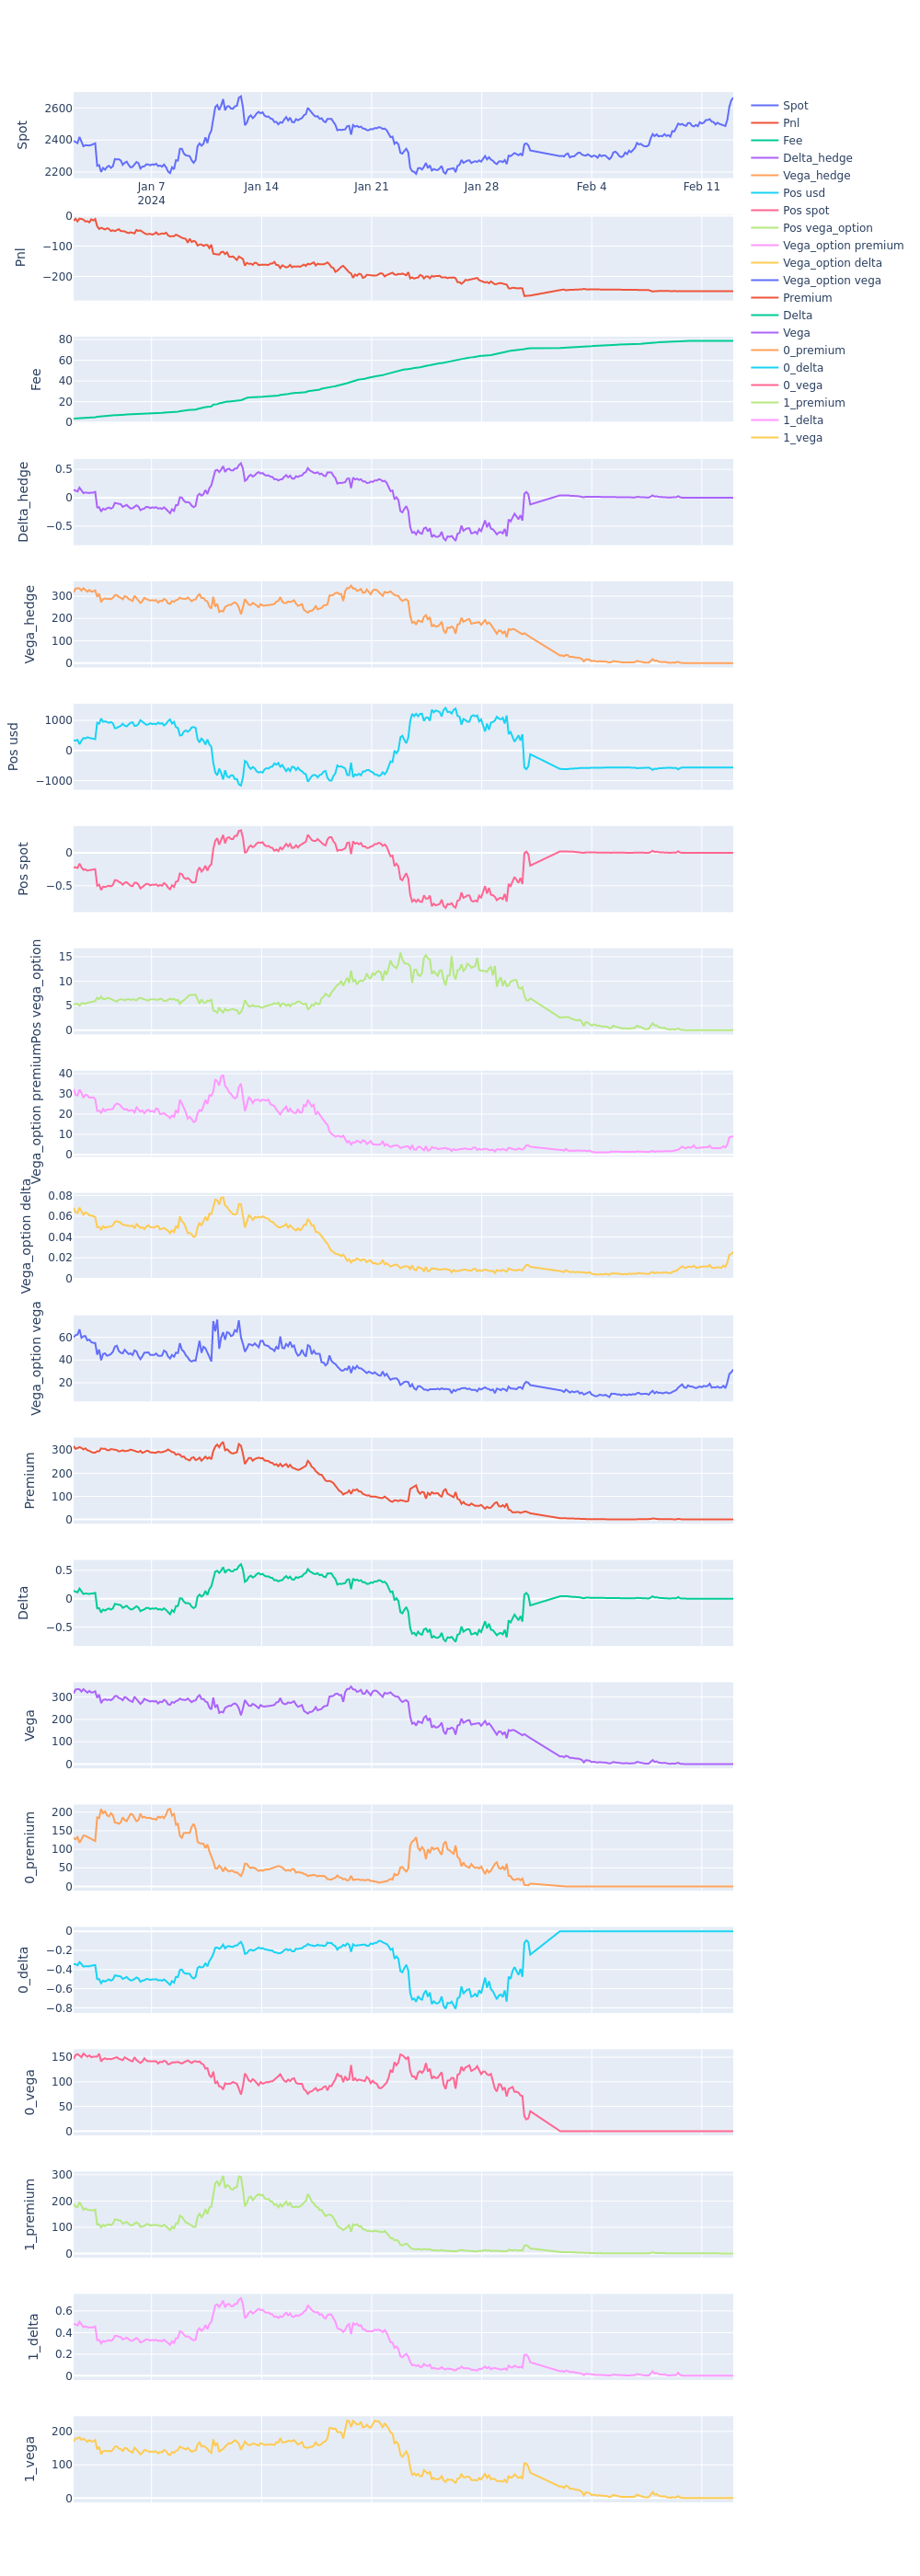

In [9]:
fig = plot_results(bt.get_results(separate_assets=True, verbose=True))
fig.update_layout(height=2800, width=1000)